In [20]:
import seaborn as sns
import numpy as np 
import json
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import pathlib
import glob

import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
import torchvision
from torch.optim import Adam

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = ('data/Training/')
path_test = ('data/Testing/')

In [3]:
img_size= 300

for i in os.listdir(path_train):
    for j in os.listdir(path_train+i):
        train_img.append (cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels.append(i)
        
for i in os.listdir(path_test):
    for j in os.listdir(path_test+i):
        test_img.append (cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels.append(i)
        
train_img = (np.array(train_img))
test_img = (np.array(test_img))


train_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(train_labels)]
test_labels_encoded = [0 if category == 'no_tumor' else(1 if category == 'glioma_tumor' else(2 if category=='meningioma_tumor' else 3)) for category in list(test_labels)]

In [4]:
print("Shape of train: ",(train_img).shape," and shape of test: ", (test_img).shape)

Shape of train:  (2870, 300, 300, 3)  and shape of test:  (394, 300, 300, 3)


## Data Inspection

In [5]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(train_img)
img_datagen.fit(test_img)

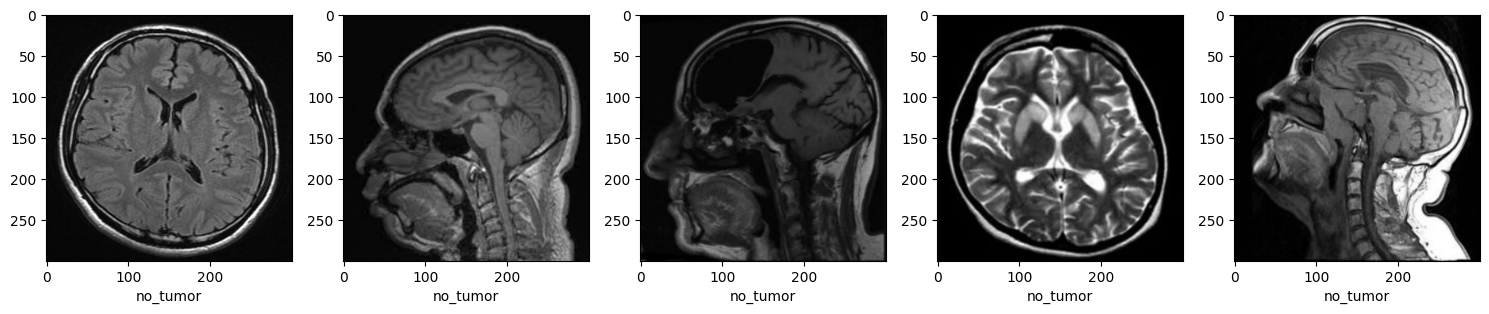

In [6]:
plt.figure(figsize = (15,15));
for i,j in enumerate(train_img):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(j);
        plt.xlabel(train_labels[i]);
        plt.tight_layout()
    else:
        break

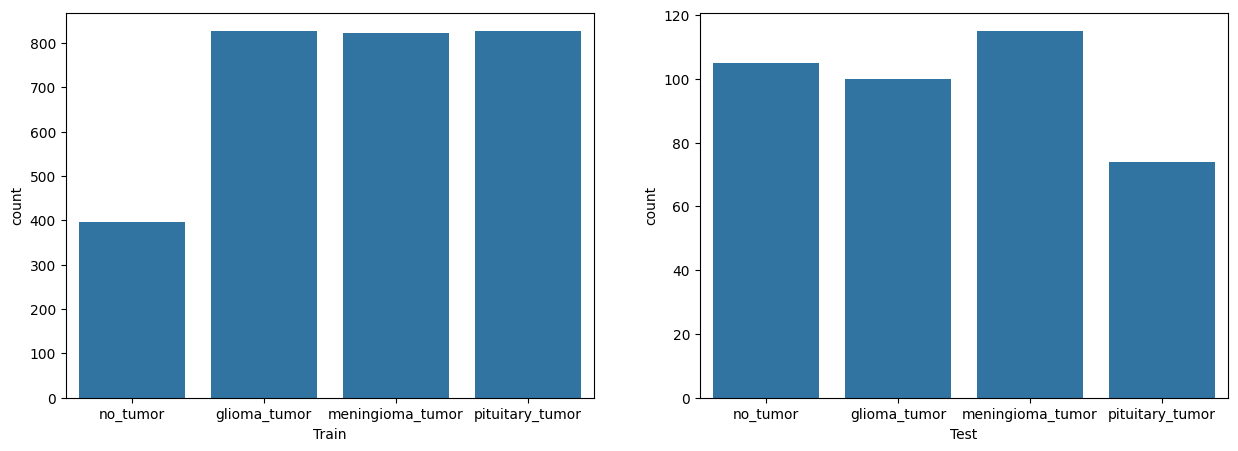

In [7]:
plt.figure(figsize = (15,5));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])


## Data preparation 

In [8]:
train_x, val_x, train_y, val_y = train_test_split(np.array(train_img), np.array(train_labels), test_size = 0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

In [9]:
transforming_img = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.5,0.5,0.5], 
                        [0.5,0.5,0.5])])

In [10]:
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(path_train,transform=transforming_img),
    batch_size=64, shuffle=True)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(path_test,transform=transforming_img),
    batch_size=32, shuffle=True)

#categories
root=pathlib.Path(path_train)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [11]:
print(f'Categories: {classes}')

Categories: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [12]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

train_count=len(glob.glob(path_train+'/**/*.jpg'))
test_count=len(glob.glob(path_test+'/**/*.jpg'))

In [13]:
# simple convolutional neural network for image classification.
class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

    #Feed forwad function    
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*75*75)
        output=self.fc(output)  
        return output
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=ConvNet(num_classes=4).to(device)


In [14]:
for i, (images,labels) in enumerate(train_loader):
      if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())

In [15]:
images.shape

torch.Size([54, 3, 150, 150])

In [17]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

# Learning rate scheduler
# ReduceLROnPlateau scheduler
# reduces the learning rate when the test accuracy stops improving.
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True)

# Early stopping parameters
patience = 5
early_stopping_counter = 0

best_accuracy=0.0

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(20):
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    scheduler.step(test_accuracy)
    
    # Early stopping and model saving
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model.model')
        best_accuracy = test_accuracy
        best_epoch = epoch
        best_train_loss = train_loss
        best_train_accuracy = train_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch}")
            break

print(f"Best model saved at epoch {best_epoch}")
print(f"Best train loss: {best_train_loss}")
print(f"Best train accuracy: {best_train_accuracy}")
print(f"Best test accuracy: {best_accuracy}")

Epoch: 0 Train Loss: tensor(7.7317) Train Accuracy: 0.6648083623693379 Test Accuracy: 0.5609137055837563
Epoch: 1 Train Loss: tensor(1.1688) Train Accuracy: 0.8616724738675958 Test Accuracy: 0.5862944162436549
Epoch: 2 Train Loss: tensor(0.7911) Train Accuracy: 0.8811846689895471 Test Accuracy: 0.6548223350253807
Epoch: 3 Train Loss: tensor(0.4659) Train Accuracy: 0.9153310104529617 Test Accuracy: 0.6776649746192893
Epoch: 4 Train Loss: tensor(0.3528) Train Accuracy: 0.9341463414634147 Test Accuracy: 0.7208121827411168
Epoch: 5 Train Loss: tensor(0.2721) Train Accuracy: 0.9407665505226481 Test Accuracy: 0.6878172588832487
Epoch: 6 Train Loss: tensor(0.2258) Train Accuracy: 0.9529616724738676 Test Accuracy: 0.6852791878172588
Epoch: 7 Train Loss: tensor(0.1945) Train Accuracy: 0.962020905923345 Test Accuracy: 0.7309644670050761
Epoch: 8 Train Loss: tensor(0.1334) Train Accuracy: 0.9662020905923345 Test Accuracy: 0.6979695431472082
Epoch: 9 Train Loss: tensor(0.1207) Train Accuracy: 0.96

In [18]:
metrics = {
    'train_losses': [loss.item() for loss in train_losses],
    'train_accuracies': [acc for acc in train_accuracies],
    'test_accuracies': [acc for acc in test_accuracies],
    'best_epoch': best_epoch,
    'best_train_loss': best_train_loss.item(),
    'best_train_accuracy': best_train_accuracy,
    'best_test_accuracy': best_accuracy
}

with open('training_metrics.json', 'w') as f:
    json.dump(metrics, f)

In [19]:
# show model architecture
print(model)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=4, bias=True)
)


In [ ]:
from torchsummary import summary
summary(model, (3, 150, 150))

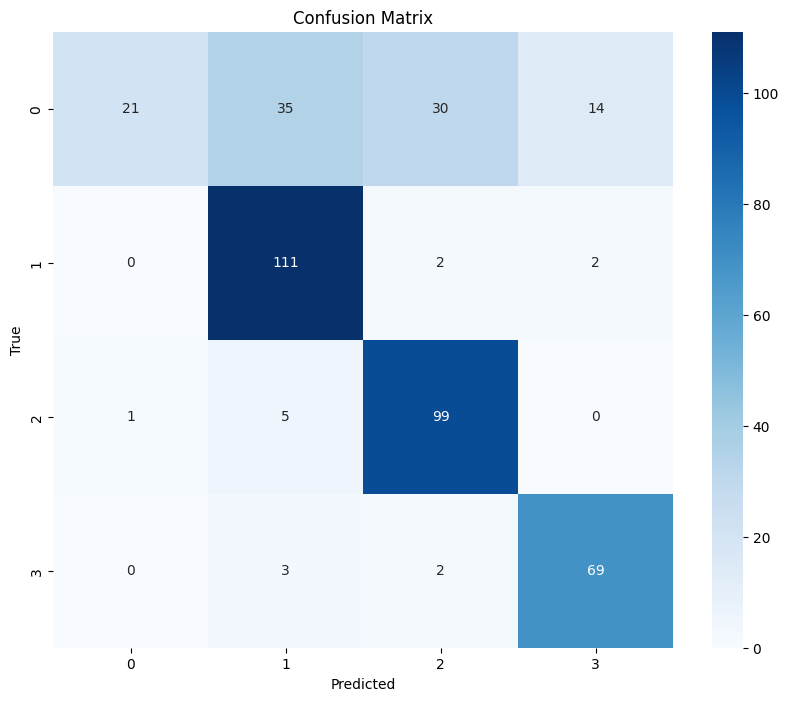

In [21]:
# confussion matrix
model.load_state_dict(torch.load('best_model.model'))
model.eval()

y_true = []
y_pred = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']))

              precision    recall  f1-score   support

    No Tumor       0.95      0.21      0.34       100
      Glioma       0.72      0.97      0.83       115
  Meningioma       0.74      0.94      0.83       105
   Pituitary       0.81      0.93      0.87        74

    accuracy                           0.76       394
   macro avg       0.81      0.76      0.72       394
weighted avg       0.80      0.76      0.71       394



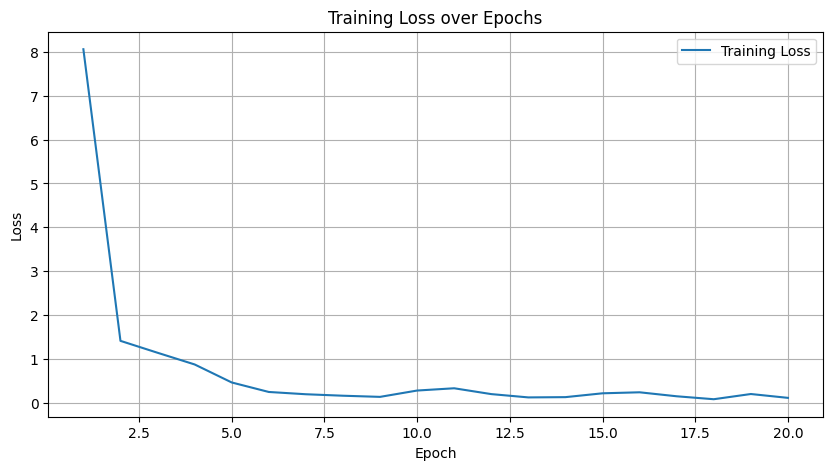

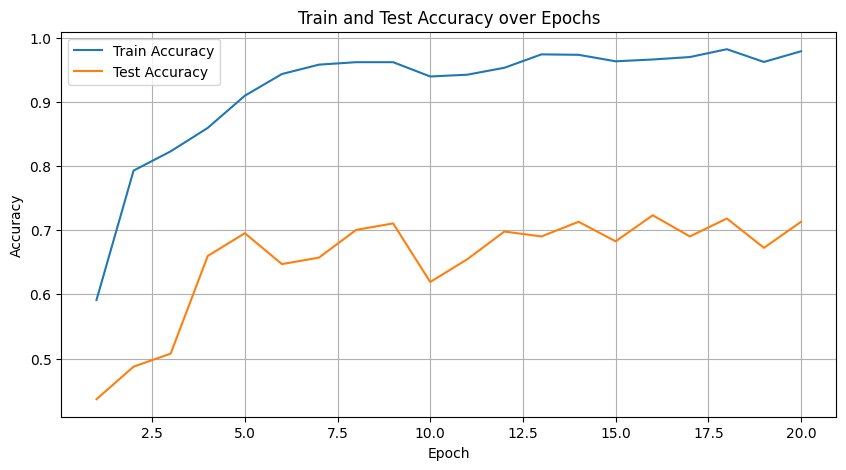

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(metrics['train_losses']) + 1), metrics['train_losses'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(metrics['train_accuracies']) + 1), metrics['train_accuracies'], label='Train Accuracy')
plt.plot(range(1, len(metrics['test_accuracies']) + 1), metrics['test_accuracies'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
best_accuracy = max(test_accuracies)
best_epoch = test_accuracies.index(best_accuracy) + 1
print(f"Best test accuracy: {best_accuracy:.4f} achieved at epoch {best_epoch}")


Best test accuracy: 0.7234 achieved at epoch 16


# Prepare model for JETSON NANO

Going to convert it to two formats that are compatible with JETSON NANO just in case one of them doesn't work.

These formats are **TorchScript** and **ONNX**.

### **TorchScript**  
TorchScript is an intermediate representation of a PyTorch model that can be executed outside the Python environment. It allows you to convert PyTorch models into a form that can be optimized, exported, and run in a production environment, including on devices like the Jetson Nano.

Benefits:
- **Performance**: TorchScript models run faster than regular PyTorch models because they are optimized for inference, reducing the overhead associated with the Python runtime.
- **Portability**: Once converted, a TorchScript model can be run independently of Python, making it ideal for edge devices, mobile apps, or web services.
- **Deployment**: You can deploy the model directly in production environments or on devices like the Jetson Nano, where Python runtime may not be efficient or available.

### **ONNX (Open Neural Network Exchange)**  
ONNX is an open format designed to represent machine learning models. It allows for interoperability between different deep learning frameworks. PyTorch models can be exported to ONNX, and this format can be used in other frameworks like TensorFlow, Caffe2, or Microsoft's ML.NET. 

The ONNX format is designed to:
- **Facilitate model sharing**: ONNX enables models to be transferred between different frameworks. This is especially useful if your deployment platform doesn’t support PyTorch natively but supports ONNX.
- **Leverage hardware acceleration**: ONNX models can be optimized using hardware accelerators like NVIDIA’s TensorRT on devices like the Jetson Nano. TensorRT takes the ONNX model and applies optimizations such as layer fusion and precision tuning to maximize speed and minimize resource usage.
- **Standardization**: ONNX provides a standardized representation of machine learning models, making it easier to maintain, optimize, and share models across different platforms and teams.

### **TorchScript vs ONNX**

- **TorchScript**: 
  - Native to PyTorch, supports all PyTorch functionalities.
  - Best for deploying PyTorch models with no need to switch to other frameworks.
  - Can directly run on devices like Jetson Nano using PyTorch runtime or TorchScript interpreter.
  
- **ONNX**:
  - Framework-agnostic format, enabling model interoperability between PyTorch, TensorFlow, and others.
  - Best for scenarios where you might want to switch between different frameworks or leverage platform-specific optimizations (like TensorRT for Jetson Nano).
  - Can be more efficient in inference if using hardware-optimized backends like TensorRT.


In [20]:
# load the saved state_dict
model.load_state_dict(torch.load('best_model.model'))
# set the model to evaluation mode
model.eval()  

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=4, bias=True)
)

In [21]:
# my model's input shape is torch.Size([54, 3, 150, 150])
# so the input would be 
model_input = torch.randn(1, 3, 150, 150)

In [22]:
# convert the model to TorchScript
traced_model = torch.jit.trace(model, model_input)
traced_model.save("best_model_traced_TorchScript.pt")

In [23]:
# convert the model to ONNX
# opset version 11 was chosen because it's compatible with the target runtime that will be used for inference (TensorRT on Jetson Nano)
torch.onnx.export(model, model_input, "best_model_onnx.onnx",
                  export_params=True, opset_version=11)

In [24]:
# For the ONNX export, you might want to add names to your input and output tensors
# for easier integration with other frameworks.
torch.onnx.export(model, model_input, "best_model_onnx_inout.onnx", 
                     input_names=["input"], 
                     output_names=["output"],
                     export_params=True, 
                     opset_version=11)